## ARIMA Forecast

In [2]:
# Import Necessary Packages
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Loading data from FRED: Visa Spending Momentum Index: Discretionary: United States (VISASMIDSA)
csv_path = 'data/VISASMIDSA.csv'
data = pd.read_csv(csv_path, 
                   parse_dates=['observation_date'], 
                   index_col='observation_date')
data.sort_index(inplace=True)

In [4]:
# Checking for missing values in the data
print(data.isna().sum())

VISASMIDSA    0
dtype: int64


In [5]:
# Ensuring that the VISASMIDSA column is numeric
data['VISASMIDSA'] = pd.to_numeric(data['VISASMIDSA'], errors='coerce')

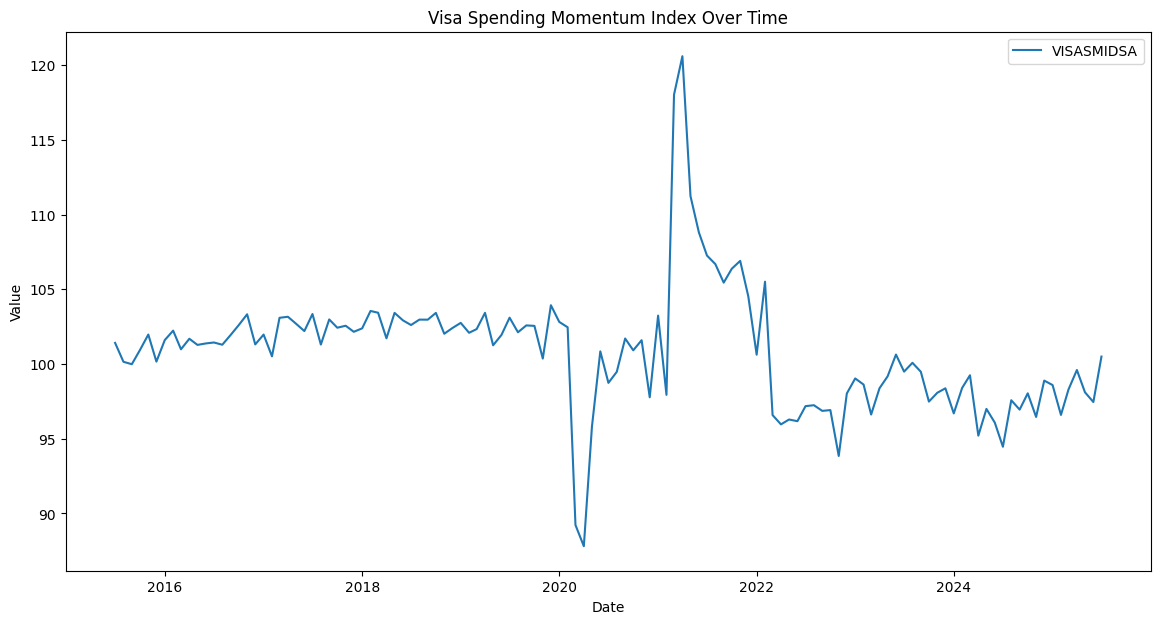

In [6]:
# Plot of the data
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['VISASMIDSA'], label='VISASMIDSA')
plt.title('Visa Spending Momentum Index Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [7]:
# Perform the Augmented Dickey-Fuller to determine if data is stationary
result = adfuller(data['VISASMIDSA'])
print(f'ADF Stat: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')

if result[1] < 0.05:
    print('The series is STATIONARY')
else:
    print('The series is NON-STATIONARY')

ADF Stat: -2.7002
p-value: 0.0740
The series is NON-STATIONARY


In [8]:
# Apply first-order differencing to correct for Non-Stationary data
data['VISASMIDSA_diff'] = data['VISASMIDSA'].diff()

# ADF test on the differenced series
result_diff = adfuller(data["VISASMIDSA_diff"].dropna())
print(f"ADF Stat (Diff): {result_diff[0]:.4f}")
print(f"p-value (Diff): {result_diff[1]:.4f}")

if result_diff[1] < 0.05:
    print('The diff series is STATIONARY')
else:
    print('The diff series is NON-STATIONARY')

ADF Stat (Diff): -3.8766
p-value (Diff): 0.0022
The diff series is STATIONARY


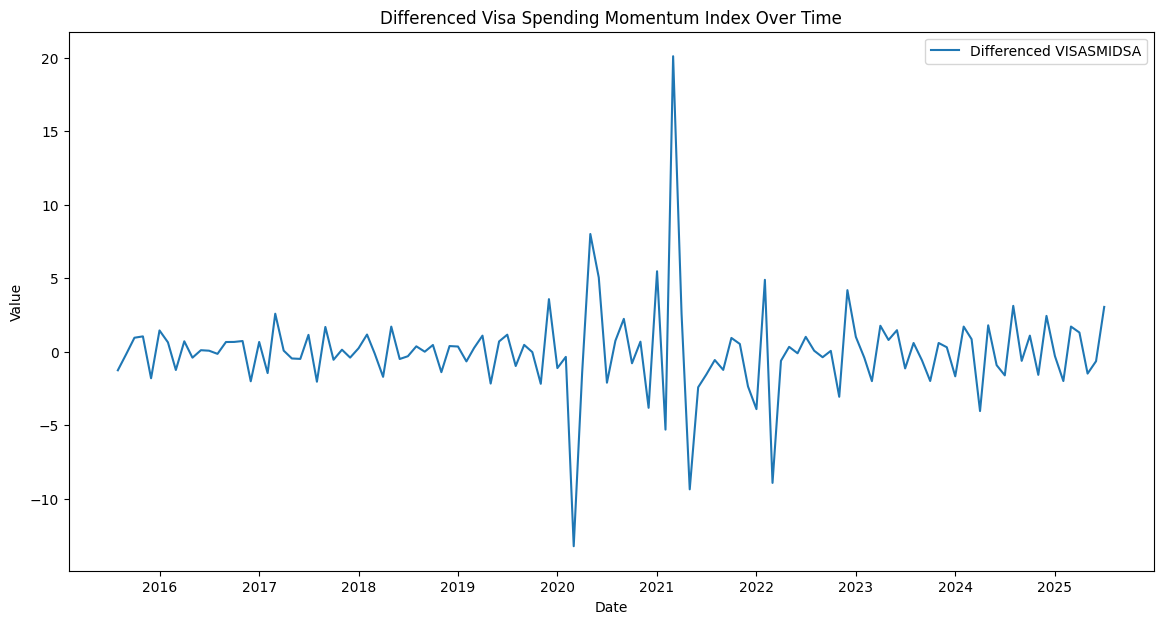

In [9]:
# Plot of differenced data
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['VISASMIDSA_diff'], label='Differenced VISASMIDSA')
plt.title('Differenced Visa Spending Momentum Index Over Time')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

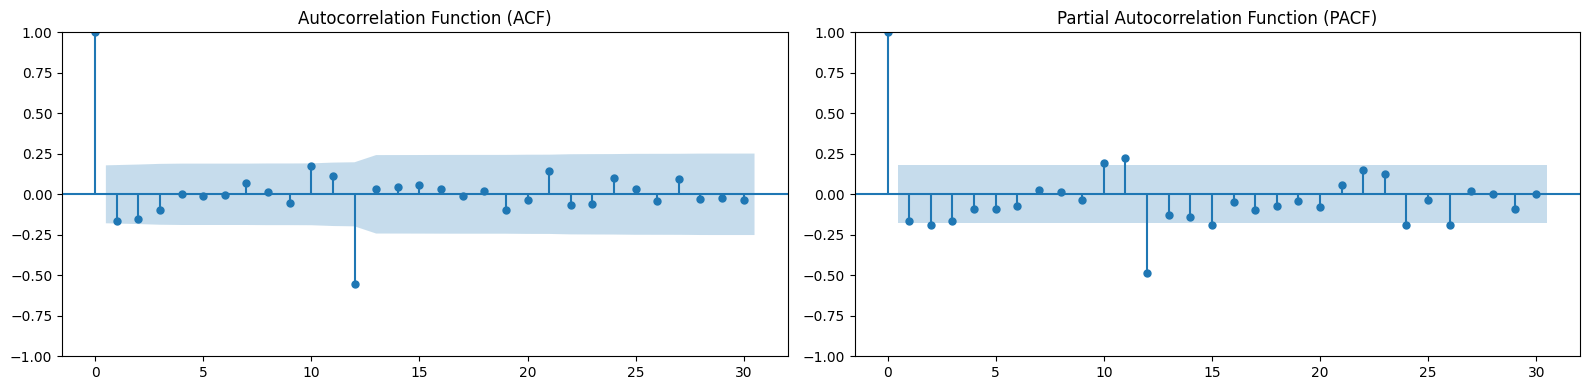

In [10]:
# Plotting ACF and PACF to determine p, d, and q values
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF
plot_acf(data['VISASMIDSA_diff'].dropna(), lags=30, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF
plot_pacf(data['VISASMIDSA_diff'].dropna(), lags=30, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [11]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Train/Test Workflow
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size-1:]

model = SARIMAX(
    train['VISASMIDSA'],
    order=(1,1,1), 
    seasonal_order=(1,1,1,12)
)

model_fit = model.fit()

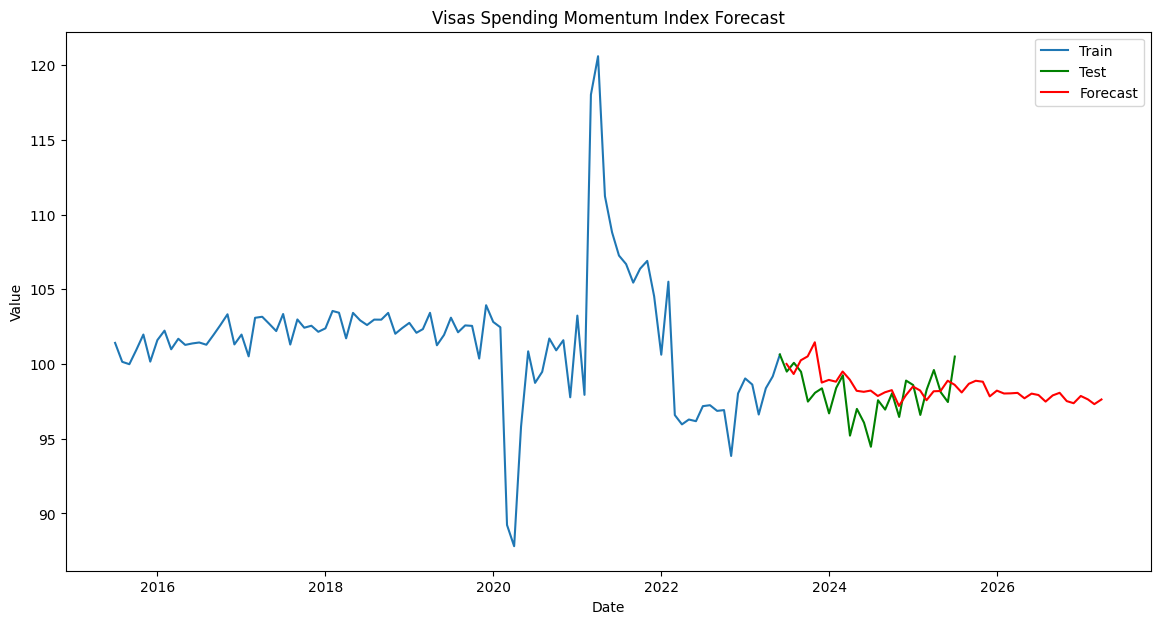

In [ ]:
# Forecast
forecast = model_fit.forecast(steps=len(test)+20) #Forecasting for an additional 20 periods
forecast_index = pd.date_range(start=test.index[0], periods=len(forecast), freq='M')

plt.figure(figsize=(14,7))
plt.plot(train.index, train['VISASMIDSA'], label='Train')
plt.plot(test.index, test['VISASMIDSA'], label='Test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red') 
plt.title('Visas Spending Momentum Index Forecast')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()